In [1]:
import pandas as pd
import numpy as np

In [2]:
df=pd.read_csv('fake-news/train.csv')

In [3]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [6]:
df.shape

(20800, 5)

In [5]:
#check for nan values
df.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [7]:
#dropping the nan values
df = df.dropna()
df.isna().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [8]:
## Get the Independent Features

X=df.drop('label',axis=1)
X.shape

(18285, 4)

In [9]:
## Get the Dependent features
y=df['label']
y.shape

(18285,)

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [11]:
### Vocabulary size
voc_size=5000

## ONE HOT REPRESENTATION

In [12]:
messages=X.copy()
messages['title'][1]

'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart'

In [13]:
messages.reset_index(inplace=True)

In [14]:
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/priya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
### Dataset Preprocessing
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [16]:
onehot_repr=[one_hot(words,voc_size)for words in corpus] 
onehot_repr

[[4503, 2876, 3866, 4748, 2727, 576, 2496, 2056, 2030, 1995],
 [2476, 1700, 403, 4043, 3070, 112, 1926],
 [4613, 2787, 964, 335],
 [1870, 443, 4299, 2381, 1999, 4035],
 [4025, 3070, 2126, 762, 1977, 2507, 3070, 1270, 4663, 1643],
 [3709,
  221,
  3815,
  2013,
  3135,
  1455,
  900,
  49,
  2566,
  1453,
  9,
  1255,
  4258,
  4606,
  1926],
 [3952, 780, 3329, 1224, 3873, 4356, 185, 2453, 4726, 748, 1003],
 [1945, 885, 2466, 1282, 1295, 394, 1455, 3114, 4726, 748, 1003],
 [1747, 332, 3236, 1352, 1394, 4757, 1173, 3643, 1455, 1897],
 [1720, 4645, 3836, 4391, 2824, 1458, 466, 3989],
 [3842, 3076, 3642, 3299, 3212, 2766, 3047, 608, 1511, 2367, 9],
 [2381, 2116, 2727, 4757, 1455, 1295],
 [2871, 4016, 534, 2815, 2667, 4028, 2524, 2156, 3642],
 [3448, 659, 11, 4841, 3953, 4094, 2708, 4726, 748, 1003],
 [377, 4088, 2780, 548, 1458, 4726, 748, 1003],
 [3230, 3558, 908, 893, 3453, 1046, 2948, 1193, 402, 2036],
 [2533, 2536, 1700],
 [4488, 4400, 4144, 2231, 1455, 2617, 3968, 1926],
 [4777, 3580,

In [17]:
sent_length=20
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 2056 2030 1995]
 [   0    0    0 ... 3070  112 1926]
 [   0    0    0 ... 2787  964  335]
 ...
 [   0    0    0 ... 4726  748 1003]
 [   0    0    0 ... 1444 1202  796]
 [   0    0    0 ... 4282  867 4695]]


In [18]:
## Creating model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 40)            200000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
len(embedded_docs),y.shape

(18285, (18285,))

In [20]:
X_final=np.array(embedded_docs)
y_final=np.array(y)
X_final.shape,y_final.shape

((18285, 20), (18285,))

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [24]:
## Finally Training
r = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
192/192 [==============================] - 6s 33ms/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 0.6232 - val_accuracy: 0.9132
Epoch 2/10
192/192 [==============================] - 6s 32ms/step - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.6090 - val_accuracy: 0.9107
Epoch 3/10
192/192 [==============================] - 6s 33ms/step - loss: 0.0016 - accuracy: 0.9998 - val_loss: 0.6361 - val_accuracy: 0.9044
Epoch 4/10
192/192 [==============================] - 7s 39ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.5876 - val_accuracy: 0.9054
Epoch 5/10
192/192 [==============================] - 8s 41ms/step - loss: 0.0026 - accuracy: 0.9992 - val_loss: 0.6057 - val_accuracy: 0.9041
Epoch 6/10
192/192 [==============================] - 6s 32ms/step - loss: 0.0080 - accuracy: 0.9974 - val_loss: 0.5993 - val_accuracy: 0.9084
Epoch 7/10
192/192 [==============================] - 10s 54ms/step - loss: 0.0060 - accuracy: 0.9982 - val_loss: 0.6630 - val_accuracy: 0.908

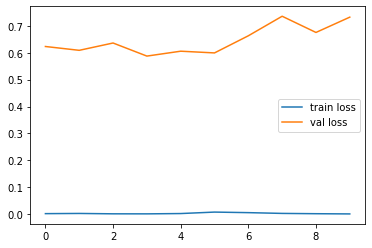

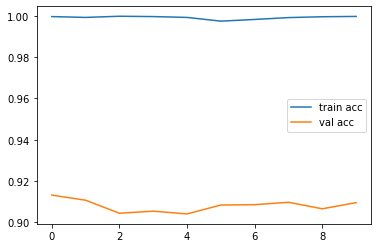

In [25]:
# loss
import matplotlib.pyplot as plt

plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [26]:
y_pred=model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[3103,  316],
       [ 230, 2386]])

In [28]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.9095277547638774